## MNIST
LeCun교수가 만든 데이터셋으로 딥러닝에서 자주 활용 되는 데이터셋이다.       
0~9까지의 숫자 필기체 이미지가 28x28 사이즈와 해당 숫자의 라벨로 이루어져 있다.   
흑백 이미지이며 train 데이터 60,000개와 test 데이터 10,000개로 구성되어 있다   


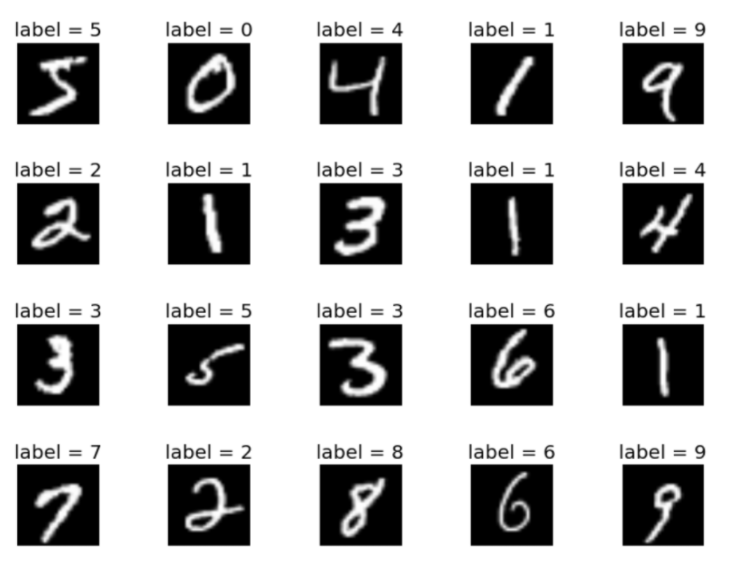

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary # optional, to see model's summary

### 1. Define Hyper-parameters and pre-set device on cuda

In [2]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

# Adjust Model Structure Depends on the Data
num_classes = 10 # label 0~9: total 10 classes
in_channel = 1 # black and white images: 1 channel (RGB: 3 channels)

# Hyper-parameters
batch_size = 10
max_pool_kernel = 2
learning_rate = 0.0001
num_epochs = 3

device: cuda


### 2. Load Data

In [3]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,                       # Train dataset을 로드
                                        transform=transforms.ToTensor(),  # MNIST 이미지는 기본적으로 PIL 이미지 형식이지만,
                                                                          # 대부분의 딥러닝 모델은 Tensor 형식의 데이터를 다루므로 변환 작업이 필요
                                        download=True)                    # 지정된 루트 디렉토리에 데이터셋이 없을 경우 자동으로 다운로드 하도록 지정
test_data = torchvision.datasets.MNIST(root='./datasets',
                                       train=False,                       # Test dataset을 로드
                                       transform=transforms.ToTensor())

### 3. Check image

In [21]:
print(f"Total train data: {len(train_data)}")
print(f"Total test data: {len(test_data)}")
print("*"*20)
print("Check data shape")

# test_data[0][0] : image
# test_data[0][1] : label
print("Data shape:",test_data[0][0].shape)
print("Data answer:",test_data[0][1])

Total train data: 60000
Total test data: 10000
********************
Check data shape
Data shape: torch.Size([1, 28, 28])
Data answer: 7


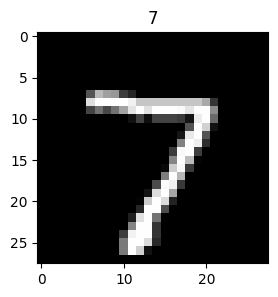

data shape: torch.Size([1, 28, 28])


In [37]:
# (1, 28, 28)로 3차원인 데이터를 (28, 28)의 2차원으로 reshape
# 2차원으로 표현해야 plt의 그래프를 통해 그릴 수 있기 때문
plt.figure(figsize=(3, 3))
plt.imshow(test_data[0][0].reshape(28, 28), cmap='gray')
plt.title(test_data[0][1]) # 해당 데이터의 label을 title로 설정
plt.show()
print("data shape:",test_data[0][0].shape)

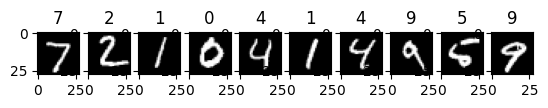

In [38]:
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(test_data[i][0].reshape(28,28), cmap='gray')
  plt.title(test_data[i][1])

In [39]:
test_data[0][0] # 0과 1 사이의 값으로 표현 --> 1에 가까울수록 진하게 나타나는 부분

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

### 4. Define DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True) # 학습 데이터의 경우에는 무작위로 섞어줌
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

**train data를 shuffle하는 것의 이점 : 모델의 일반화 성능 향상**   
데이터셋에서 미니배치를 추출하여 모델을 학습할 때, 미니배치가 순서대로 나오는 경우 모델이 특정 패턴이나 순서에 의존하여 학습할 수 있다.   
shuffle을 통해 데이터를 무작위로 섞으면 각 미니배치가 서로 다른 샘플로 구성되어 모델이 다양한 패턴을 학습하게 되며, 이는 모델이 데이터의 일반적인 특징을 학습하여 새로운 데이터에 대해 더 잘 일반화되도록 돕는다

### 5. Define Model

In [5]:
class ConvNet(nn.Module):
  def __init__(self, num_classes):
    super(ConvNet, self).__init__()

    self.layer1 = nn.Sequential( # 28x28x1 --> 28x28x16
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel) # 28x28x16 --> 14x14x16
    )
    self.layer2 = nn.Sequential( # 14x14x16 --> 14x14x32
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel) # 7x7x32
    )
    self.fc1 = nn.Linear(7*7*32, 120)
    self.fc2 = nn.Linear(120, num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)

    x = x.reshape(x.size(0), -1) # flatten
    #x = nn.ReLU(self.fc1(x))
    x = F.relu(self.fc1(x))
    #x = nn.Sigmoid(self.fc2(x))
    x = F.sigmoid(self.fc2(x))

    return x

In [6]:
model = ConvNet(num_classes).to(device)

In [7]:
# cf) see network form
print(model)

# cf) check the number of parameters
print('{:=^60}'.format("="))
print('{:^60}'.format("model summary"))
print('{:=^60}'.format("="))
for param_tensor in model.state_dict():
  print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
print('{:=^60}'.format("="))

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
                       model summary                        
layer1.0.weight                  torch.Size([16, 1, 5, 5])   
layer1.0.bias                         torch.Size([16])       
layer1.1.weight                       torch.Size([16])       
layer1.1.bias                      

### 6. Train

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_list = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Assign Tensors to Configured Device
    images = images.to(device) # 데이터를 GPU에 올려준다
    labels = labels.to(device)

    outputs = model(images) # model을 통해 예측값 산출

    loss = criterion(outputs, labels)  #loss 값을 계산(tensor로 나옴)
    optimizer.zero_grad() # gradient를 초기화
    loss.backward() # backward로 gradient 계산
    optimizer.step() # graident update

    loss_list.append(loss.detach().cpu().numpy()) # tensor인 loss를 cpu로 가져와서 numpy로 바꿔서 저장한다

    if i % 2000 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss: {}", epoch + 1, num_epochs, i, total_step, loss)

  if epoch+1 == num_epochs: # 최종 결과에 대해서만
    torch.save(model.state_dict(), 'model.pth') # pth 파일로 모델, 파라미터 등을 보기 쉽게 저장
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1)) # 0, 1, 2번째 epoch일 때(중간 epoch)의 파라미터도 저장하겠다


### 7. Test

In [19]:
# Test after training is done
model.eval() # Set model as evaluation mode (instead of mini-batch mean/var, batchnorm is used)
with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    # torch.max : 주어진 텐서에서 최댓값과 최댓값의 인덱스를 반환하는 pytorch 함수
    # torch.max(input, dim, keepdim=False) : 주어진 차원(dim)에 따라 최댓값과 최댓값의 인덱스를 반환
    t, predicted = torch.max(outputs.data, 1) # 원래는 첫 번째 출력은 필요 없어서 '_'로 둔다

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images {}%'.format(len(test_loader)*batch_size, 100*correct/total))

########### 마지막 시행 이후 출력 구조를 파악하기 위한 목적에서 출력 ###########
  print(outputs.size()) # (batch_size, num_classes)로 구성된 텐서이다
  print(outputs.data)   # batch_size만큼 데이터가 있고, 각 데이터는 총 10개(num_classes)의 클래스에 대한 확률값이다
  print(t)              # batch_size만큼의 데이터에서 최댓값을 모은 부분
  print(predicted)      # batch_size만큼의 데이터에서 최댓값의 인덱스를 모은 부분 --> MNIST의 어떤 숫자(클래스)인지에 일치
################################################################################

Accuracy of the network on the 10000 test images 98.68%
torch.Size([10, 10])
tensor([[2.1540e-12, 1.3078e-04, 1.1034e-06, 1.1328e-05, 4.9140e-14, 2.7911e-12,
         4.3525e-20, 1.0000e+00, 5.6127e-11, 7.7588e-10],
        [7.6881e-09, 1.0364e-07, 1.1650e-07, 1.3116e-04, 5.0297e-17, 1.4062e-03,
         5.1946e-10, 1.1680e-10, 1.0000e+00, 3.6927e-14],
        [1.4632e-09, 1.4585e-12, 8.7954e-10, 1.1792e-06, 9.4041e-05, 2.1360e-09,
         5.2958e-15, 9.1669e-08, 2.9373e-09, 9.9999e-01],
        [1.0000e+00, 2.6271e-10, 5.5817e-08, 3.0867e-06, 9.5187e-13, 8.2184e-05,
         2.0732e-06, 3.4759e-12, 3.6596e-03, 1.3895e-06],
        [1.1271e-05, 1.0000e+00, 3.1558e-05, 1.7273e-07, 3.5036e-06, 3.2075e-08,
         5.0712e-06, 1.2083e-05, 6.6273e-07, 1.1111e-07],
        [4.9023e-10, 8.0882e-06, 1.0000e+00, 1.4470e-08, 1.3829e-18, 1.0280e-15,
         5.0751e-14, 6.6020e-06, 1.7259e-12, 1.8098e-16],
        [1.1140e-06, 2.1598e-06, 3.6586e-07, 1.0000e+00, 2.2815e-17, 3.6458e-03,
        

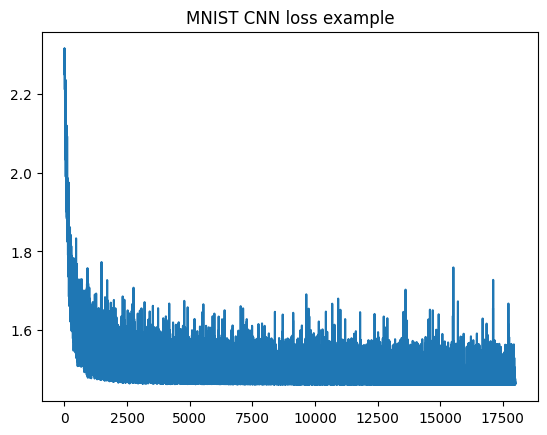

In [12]:
plt.plot(loss_list)
plt.title("MNIST CNN loss example")
plt.show()